In [2]:
import numpy as np
import matplotlib.pyplot as plt

def make_swiss_roll(n=500, noise=0.0):
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(n))
    X = np.zeros((n,3))
    X[:,0] = t * np.cos(t)
    X[:,1] = 21 * np.random.rand(n)
    X[:,2] = t * np.sin(t)
    X += noise * np.random.randn(n,3)
    return X, t

X, color = make_swiss_roll(n=500, noise=0.05)

In [3]:
X.shape

(500, 3)

In [4]:
def pca(X, d=2):
    Xc = X - X.mean(axis=0)
    C = Xc.T.dot(Xc) / (Xc.shape[0]-1)
    vals, vecs = np.linalg.eigh(C)
    idx = np.argsort(vals)[::-1]
    V = vecs[:, idx[:d]]
    return Xc.dot(V)

Y_pca = pca(X, d=2)

In [7]:
def sne(X, d=2, sigma=1.0, lr=100.0, iters=300):
    n = X.shape[0]

    # step 1: compute high-dim affinities P_ij (symmetric)
    #    P_ij ∝ exp(-||x_i-x_j||^2 / (2σ^2)), zero diag, normalized to sum=1

    sq = np.sum(X*X, axis=1)
    D2 = sq[:, None] + sq[None, :] - 2 * X.dot(X.T)
    P = np.exp(-D2 / (2 * sigma**2))
    np.fill_diagonal(P, 0)
    P /= P.sum()

    # step: intit low-dim points
    Y = 0.0001 * np.random.randn(n, d)

    for _ in range(iters):
        # Compute low-dim affinities Q_ij ∝ exp(-||y_i-y_j||^2)
        sqy = np.sum(Y*Y, axis=1)
        d2y = sqy[:,None] + sqy[None,:] - 2 * Y.dot(Y.T)
        Q = np.exp(-d2y / (2 * sigma**2))
        np.fill_diagonal(Q, 0)
        Q /= Q.sum()

        # Gradient of C = ∑ P_ij log(P_ij / Q_ij)
        # dC/dy_i = 2 * ∑_j (P_ij - Q_ij) (y_i - y_j)
        PQ = P - Q
        grad = np.zeros_like(Y)
        for i in range(n):
            # vectorized difference: Y[i] - Y => shape (n,d)
            diff = Y[i] - Y
            grad[i] = 2 * np.sum(PQ[i][:,None] * diff, axis=0)

        # gd step
        Y -= lr * grad

        Y -= Y.mean(axis=0)
    return Y

Y_sne = sne(X, d=2, sigma=5.0, lr=100.0, iters=500)

In [9]:
def tsne(X, d=2, sigma=1.0, lr=200.0, iters=500):
    n = X.shape[0]

    # compute high-dim affinities P_ij symmetrically
    sq = np.sum(X * X, axis=1)
    D2 = sq[:,None] + sq[None,:] - 2 * X.dot(X.T)
    P = np.exp(-D2 / (2 * sigma**2))
    np.fill_diagonal(P, 0)
    P = (P + P.T) / (2 * P.sum())   

    # init low-dim points
    Y = 1e-4 * np.random.randn(n, d)

    for _ in range(iters):
        # compute low-dim affinities Q_ij via Student-t (v=1)
        sqy = np.sum(Y * Y, axis=1)
        num = 1 / (1 + (sqy[:,None] + sqy[None,:] - 2*Y.dot(Y.T)))
        np.fill_diagonal(num, 0)
        Q = num / num.sum()

        # grad descent
        PQ = P - Q
        grad = np.zeros_like(Y)
        for i in range(n):
            diff = Y[i] - Y     
            grad[i] = 4 * np.sum((PQ[i][:,None] * num[i][:,None]) * diff, axis=0)

        Y -= lr * grad
        Y -= Y.mean(axis=0)
    return Y

Y_tsne = tsne(X, d=2, sigma=5.0, lr=200.0, iters=500)

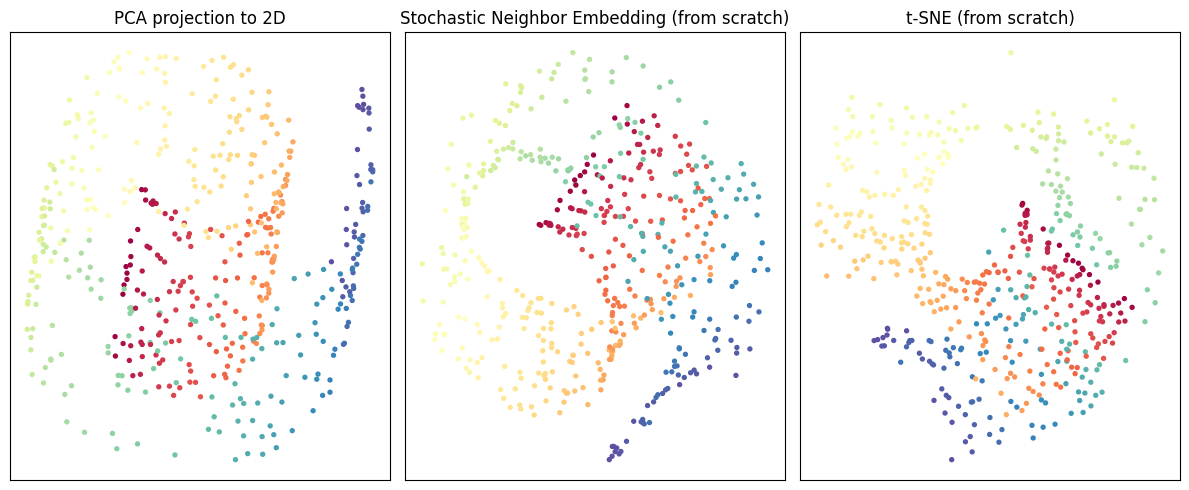

In [11]:
fig, axs = plt.subplots(1,3, figsize=(12,5))

axs[0].scatter(Y_pca[:,0], Y_pca[:,1], c=color, cmap="Spectral", s=8)
axs[0].set_title("PCA projection to 2D")
axs[0].set_xticks([]); axs[0].set_yticks([])

axs[1].scatter(Y_sne[:,0], Y_sne[:,1], c=color, cmap="Spectral", s=8)
axs[1].set_title("Stochastic Neighbor Embedding (from scratch)")
axs[1].set_xticks([]); axs[1].set_yticks([])

axs[2].scatter(Y_tsne[:,0], Y_tsne[:,1], c=color, cmap="Spectral", s=8)
axs[2].set_title("t-SNE (from scratch)")
axs[2].set_xticks([]); axs[2].set_yticks([])

plt.tight_layout()
plt.show()